In [5]:
%matplotlib inline
import tvm
from tvm import te
import timeit
import numpy as np

target = 'llvm -mcpu=tigerlake'

In [2]:
def bench_workload(workload):
    """Benchmark a workload
    workload: a method that accept a num_repeat argument
    and return its total execution time
    """
    workload(1)  # warmup
    time = workload(1)  # the time to run once
    if time > 1: return time
    # The number of repeats to measure at least 1 second
    num_repeats = max(int(1.0 / time), 5)
    return workload(num_repeats) / num_repeats

In [6]:
def np_matmul_timer(n):
    timer = timeit.Timer(setup='import numpy as np\n'
                         'import utils\n'
                         'a, b, c = utils.get_abc(%s)' % str((n,n)),
                         stmt = 'np.dot(a, b, out=c)')
    return timer.timeit

In [7]:
sizes = 2**np.arange(5, 12, 1)
exe_times = [bench_workload(np_matmul_timer(n)) for n in sizes]
np_gflops = 2 * sizes **3 / 1e9 / np.array(exe_times)

In [8]:
def matmul(n, m, l):
    """Return the computing expression of matrix multiplication
    A : n x l matrix
    B : l x m matrix
    C : n x m matrix with C = A B
    """
    k = te.reduce_axis((0, l), name='k')
    A = te.placeholder((n, l), name='A')
    B = te.placeholder((l, m), name='B')
    C = te.compute((n, m),
                    lambda x, y: te.sum(A[x, k] * B[k, y], axis=k),
                    name='C')
    return A, B, C

In [9]:
tx, ty, tk = 32, 32, 4  # tile sizes

def block(n):
    A, B, C = matmul(n, n, n)
    s = te.create_schedule(C.op)
    # Tile by blocks, and then parallelize the computation of each block
    xo, yo, xi, yi = s[C].tile(*C.op.axis, tx, ty)
    xy = s[C].fuse(xo, yo)
    s[C].parallel(xy)
    # Optimize the computation of each block
    ko, ki = s[C].split(s[C].op.reduce_axis[0], factor=tk)
    s[C].reorder(ko, xi, ki, yi)
    s[C].vectorize(yi)
    s[C].unroll(ki)
    return s, (A, B, C)

s, (A, B, C) = block(64)
print(tvm.lower(s, [A, B, C], simple_mode=True))

@main = primfn(A_1: handle, B_1: handle, C_1: handle) -> ()
  attr = {"from_legacy_te_schedule": True, "global_symbol": "main", "tir.noalias": True}
  buffers = {A: Buffer(A_2: Pointer(float32), float32, [4096], []),
             B: Buffer(B_2: Pointer(float32), float32, [4096], []),
             C: Buffer(C_2: Pointer(float32), float32, [4096], [])}
  buffer_map = {A_1: A, B_1: B, C_1: C}
  preflattened_buffer_map = {A_1: A_3: Buffer(A_2, float32, [64, 64], []), B_1: B_3: Buffer(B_2, float32, [64, 64], []), C_1: C_3: Buffer(C_2, float32, [64, 64], [])} {
  for (x.outer.y.outer.fused: int32, 0, 4) "parallel" {
    for (x.inner.init: int32, 0, 32) {
      C[ramp((((floordiv(x.outer.y.outer.fused, 2)*2048) + (x.inner.init*64)) + (floormod(x.outer.y.outer.fused, 2)*32)), 1, 32)] = broadcast(0f32, 32)
    }
    for (k.outer: int32, 0, 16) {
      for (x.inner: int32, 0, 32) {
        let cse_var_5: int32 = (floormod(x.outer.y.outer.fused, 2)*32)
        let cse_var_4: int32 = ((floordiv(x.

In [10]:
import utils

def bench_matmul_tvm(func, sizes, target):
    def workload(nrepeats):
        dev = tvm.device(target)
        timer = mod.time_evaluator(mod.entry_name, dev=dev, number=nrepeats)
        return timer(a, b, c).mean * nrepeats
    times = []
    for n in sizes:
        s, (A, B, C) = func(int(n))
        mod = tvm.build(s, [A, B, C], target)
        a, b, c = utils.get_abc((n, n), lambda x: tvm.nd.array(x))
        times.append(bench_workload(workload))
    return 2 * sizes**3 / 1e9 / np.array(times)

In [11]:
from IPython import display
import numpy as np
from matplotlib import pyplot as plt

# Defined in file: ./chapter_cpu_schedules/vector_add.md
def plot(X, Y, xlabel=None, ylabel=None, legend=[], xlim=None,
         ylim=None, xscale='linear', yscale='linear', fmts=None,
         figsize=(4.5, 3)):
    """Plot multiple lines"""
    display.set_matplotlib_formats('svg')
    plt.rcParams['figure.figsize'] = figsize
    axes = plt.gca()
    X, Y = np.array(X), np.array(Y)
    if X.shape != Y.shape: X = [X] * len(Y)
    if not fmts: fmts = ['-'] * len(X)
    for x, y, fmt in zip(X, Y, fmts):
        axes.plot(x, y, fmt)
    axes.set_xlabel(xlabel)
    axes.set_ylabel(ylabel)
    axes.set_xscale(xscale)
    axes.set_yscale(yscale)
    axes.set_xlim(xlim)
    axes.set_ylim(ylim)
    if legend: axes.legend(legend)
    axes.grid()


# Defined in file: ./chapter_cpu_schedules/vector_add.md
def plot_gflops(sizes, gflops, legend, xlabel='Size'):
    plot(sizes, gflops, xlabel=xlabel, ylabel='GFLOPS',
             xscale='log', yscale='log',
             legend=legend, fmts=['--']*(len(gflops)-1)+['-'])

/tmp/ipykernel_7219/1797096178.py:10: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


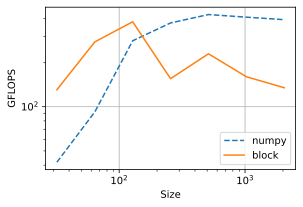

In [12]:
blocked_gflops = bench_matmul_tvm(block, sizes, target)
plot_gflops(sizes, [np_gflops, blocked_gflops], ['numpy', 'block'])

In [13]:
def cached_block(n):
    A, B, C = matmul(n, n, n)
    s = te.create_schedule(C.op)
    # Create a write cache for C
    CachedC = s.cache_write(C, 'local')
    # Same as before, first tile by blocks, and then parallelize the
    # computation of each block
    xo, yo, xi, yi = s[C].tile(*C.op.axis, tx, ty)
    xy = s[C].fuse(xo, yo)
    s[C].parallel(xy)
    # Use the write cache for the output of the xy axis, namely a block.
    s[CachedC].compute_at(s[C], xy)
    # Same as before to optimize the computation of a block .
    xc, yc = s[CachedC].op.axis
    ko, ki = s[CachedC].split(CachedC.op.reduce_axis[0], factor=tk)
    s[CachedC].reorder(ko, xc, ki, yc)
    s[CachedC].unroll(ki)
    s[CachedC].vectorize(yc)
    return s, (A, B, C)

s, (A, B, C) = cached_block(512)
print(tvm.lower(s, [A, B, C], simple_mode=True))

@main = primfn(A_1: handle, B_1: handle, C_1: handle) -> ()
  attr = {"from_legacy_te_schedule": True, "global_symbol": "main", "tir.noalias": True}
  buffers = {A: Buffer(A_2: Pointer(float32), float32, [262144], []),
             B: Buffer(B_2: Pointer(float32), float32, [262144], []),
             C: Buffer(C_2: Pointer(float32), float32, [262144], [])}
  buffer_map = {A_1: A, B_1: B, C_1: C}
  preflattened_buffer_map = {A_1: A_3: Buffer(A_2, float32, [512, 512], []), B_1: B_3: Buffer(B_2, float32, [512, 512], []), C_1: C_3: Buffer(C_2, float32, [512, 512], [])} {
  for (x.outer.y.outer.fused: int32, 0, 256) "parallel" {
    allocate(C.local: Pointer(local float32), float32, [1024]), storage_scope = local {
      for (x.c.init: int32, 0, 32) {
        C.local_1: Buffer(C.local, float32, [1024], [], scope="local")[ramp((x.c.init*32), 1, 32)] = broadcast(0f32, 32)
      }
      for (k.outer: int32, 0, 128) {
        for (x.c: int32, 0, 32) {
          let cse_var_3: int32 = (x.c*32)
 

/tmp/ipykernel_7219/1797096178.py:10: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


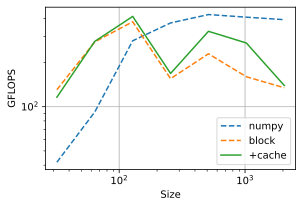

In [14]:
cached_gflops = bench_matmul_tvm(cached_block, sizes, target)
plot_gflops(sizes, [np_gflops, blocked_gflops, cached_gflops],
            ['numpy', 'block', '+cache'])